In [1]:
import keras,os
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,UpSampling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


LOADING PRE-TRAINED VGG16 BASE-NET

In [2]:
model=keras.applications.vgg16.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 6s 0us/step


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
m1 = Model(inputs=model.input,outputs=[model.get_layer('block1_pool').output,
                                      model.get_layer('block2_pool').output,model.get_layer('block3_pool').output,
                                      model.get_layer('block4_pool').output,model.get_layer('block5_pool').output,
                                      model.get_layer('fc2').output])

In [5]:
m1.output_names

['block1_pool',
 'block2_pool',
 'block3_pool',
 'block4_pool',
 'block5_pool',
 'fc2']

In [6]:
m1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
sf = Dense(2,activation='softmax')(m1.outputs[5])

In [8]:
model1 = Model(inputs=m1.input,outputs=sf)


In [9]:
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
for layer in model1.layers[:-3]:
    layer.trainable = False

LOADIND DATA OF SPIDER OF SMALL AND LARGE SCALE

In [11]:
catog = ['non-spider','spider']
size = 224

In [12]:
datadir = "../input/spider/01/01"

In [13]:
data=[]
def img_data_create():
    for cat in catog:
        path = os.path.join(datadir,cat)
        class_num = catog.index(cat)
        '''if class_num==0:
            lab=[1,0]
        else:
            lab=[0,1]'''
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(size,size))
                data.append([new_array,class_num])
            except Exception as e:
                pass
img_data_create()

In [14]:
X=[]
y=[]

In [15]:
import random
random.shuffle(data)

In [16]:
for feat,label in data:
    X.append(feat)
    y.append(label)

In [17]:
X = np.array(X).reshape(-1,size,size,3)
y = np.array(y).reshape(-1,1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
y_train[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

FINE-TUNING MODEL WITH ALL SCALE IMAGES OF SPIDER

model1.compile(optimizer=keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model1.fit(x=X_train,y=y_train,epochs=2,batch_size =64)

In [20]:
for layer in model1.layers:
    layer.trainable = True
model1.compile(optimizer=keras.optimizers.Adam(1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model1.fit(x=X_train,y=y_train,epochs=2,batch_size =64)

Epoch 1/2
450/450 [==============================] - 11s 24ms/step - loss: 0.3500 - accuracy: 0.8844
Epoch 2/2
450/450 [==============================] - 4s 8ms/step - loss: 0.0193 - accuracy: 0.9956


In [21]:
model1.evaluate(X_test,y_test)

113/113 [==============================] - 1s 13ms/step


[0.03484218796731624, 0.991150438785553]

In [22]:
datadir2 = "../input/spider/02/02"

In [23]:
catog2 = ['non-spider','small-scale-spiders']

LOADIND DATA OF ONLY SMALL SCALE SPIDER

In [24]:
data=[]
def img_data_create():
    for cat in catog2:
        path = os.path.join(datadir2,cat)
        class_num = catog2.index(cat)
        '''if class_num==0:
            lab=[1,0]
        else:
            lab=[0,1]'''
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(size,size))
                data.append([new_array,class_num])
            except Exception as e:
                pass
img_data_create()

In [25]:
X1=[]
y1=[]

In [26]:
import random
random.shuffle(data)

In [27]:
for feat,label in data:
    X1.append(feat)
    y1.append(label)

In [28]:
X1 = np.array(X1).reshape(-1,size,size,3)
y1 = np.array(y1).reshape(-1,1)

In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [30]:
X1.shape

(214, 224, 224, 3)

In [31]:
model1.compile(optimizer=keras.optimizers.Adam(1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

FINE-TUNING MODEL WITH ONLY SMALL SCALE SPIDER

In [32]:
model1.fit(x=X_train1,y=y_train1,epochs=2,batch_size = 64)

Epoch 1/2
171/171 [==============================] - 4s 25ms/step - loss: 0.0642 - accuracy: 0.9766
Epoch 2/2
171/171 [==============================] - 1s 8ms/step - loss: 5.3899e-04 - accuracy: 1.0000


In [33]:
model1.evaluate(X_test1,y_test1)

43/43 [==============================] - 1s 12ms/step


[0.0046351649514182885, 1.0]

MODEL FOR FEATURE ACTIVATION MAP WITH COMBINED FEATURE MAP OF ALL CONV BLOCKS

In [66]:
up1=(m1.outputs[0])
up2=(m1.outputs[1])
up3=(m1.outputs[2])
up4=(m1.outputs[3])
up5=(m1.outputs[4])

In [67]:
up1 = Conv2D(1, (1, 1), activation='relu',kernel_initializer='ones' ,padding='same', name='up1')(up1)
up2 = Conv2D(1, (1, 1), activation='relu',kernel_initializer='ones' , padding='same', name='up2')(up2)
up3 = Conv2D(1, (1, 1), activation='relu', kernel_initializer='ones' ,padding='same', name='up3')(up3)
up4 = Conv2D(1, (1, 1), activation='relu',kernel_initializer='ones' , padding='same', name='up4')(up4)
up5 = Conv2D(1, (1, 1), activation='relu',kernel_initializer='ones' , padding='same', name='up5')(up5)
#added = keras.layers.Add(trainable=False)([up1,up2,up3,up4,up5])

In [70]:
up1 = UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(up1)
up1.shape
up2 = UpSampling2D(size=(4, 4), data_format=None, interpolation='bilinear')(up2)
up2.shape
up3 = UpSampling2D(size=(8, 8), data_format=None, interpolation='bilinear')(up3)
up4 = UpSampling2D(size=(16, 16), data_format=None, interpolation='bilinear')(up4)
up5 = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(up5)
added = keras.layers.Add(trainable=False)([up1,up2,up3,up4])

In [71]:
model2 = Model(inputs=m1.input,outputs=[sf,up1,up2,up3,up4,up5,added])

In [76]:
y,im1,im2,im3,im4,im5,out=model2.predict(X1[0:30])
i=4

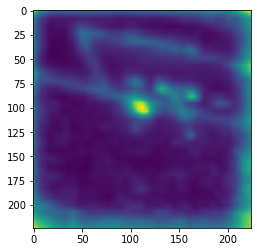

In [77]:
out2=plt.imshow(out[i][:,:,0],cmap='viridis')

HEATMAP OUTPUT OF FEATURE ACTIVATION MAP

heatmap2 = cv2.applyColorMap(np.uint8(X[i]), cv2.COLORMAP_JET)
out1 = plt.imshow(heatmap2)

[2.8625676e-05 9.9997139e-01]


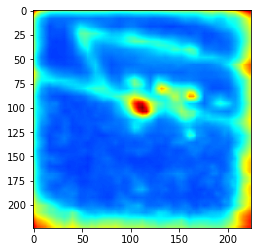

In [78]:
img=out[i][:,:,0]
img /= np.max(img)
#heatmap[np.where(img < 0.3)] = 1
img = [1] - img
#cam[np.where(img < 0.1)] = 1
#cam[np.where(img < 0.2)] +=0.8
heatmap = cv2.applyColorMap(np.uint8(img*255), cv2.COLORMAP_JET)
#heatmap[np.where(img < 0.2)] =0 
heatmap= heatmap
out2=plt.imshow(heatmap)
print(y[i])

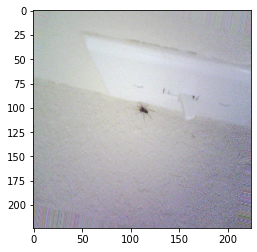

In [79]:
inp1=plt.imshow(X1[i])


height=224
width=224
cam1=im1[i][:,:,0]
cam1 /= np.max(cam1)
cam1 = [1] - cam1
#cam1 = cv2.resize(cam1, (height, width))
heatmap1 = cv2.applyColorMap(np.uint8(255*cam1), cv2.COLORMAP_JET)
heatmap1[np.where(cam1 > 0.3)] = 0
img1 = heatmap1
#img1 = cv2.resize(img1, (height, width))
#img1 = cv2.resize(img1,(height,width,3))


cam2=im2[i][:,:,0]
cam2 /= np.max(cam2)
cam2 = [1] - cam2
#cam2 = cv2.resize(cam2, (height, width))
heatmap2 = cv2.applyColorMap(np.uint8(255*cam2), cv2.COLORMAP_JET)
heatmap2[np.where(cam2 > 0.3)] = 0
img2 =heatmap2

cam3=im3[i][:,:,0]
cam3 /= np.max(cam3)
cam3 = [1] - cam3
#cam3 = cv2.resize(cam3, (height, width))
heatmap3 = cv2.applyColorMap(np.uint8(255*cam3), cv2.COLORMAP_JET)
heatmap3[np.where(cam3 > 0.3)] = 0
img3 =heatmap3

cam4=im4[i][:,:,0]
cam4 /= np.max(cam4)
cam4 = [1] - cam4
#cam4 = cv2.resize(cam4, (height, width))
heatmap4 = cv2.applyColorMap(np.uint8(255*cam4), cv2.COLORMAP_JET)
#heatmap4[np.where(cam4 > 0.3)] = 0
img4 = heatmap4 

cam5=im5[i][:,:,0]
cam5 /= np.max(cam5)
#cam5 = [1] - cam5
#cam5 = cv2.resize(cam5, (height, width))
heatmap5 = cv2.applyColorMap(np.uint8(255*cam5), cv2.COLORMAP_JET)
#heatmap5[np.where(cam5 < 0.2)] =0
img5 = heatmap5
img = heatmap
#heatmap[np.where(cam3 < 0.5)] = 0

imgf= cv2.addWeighted(heatmap,0.9,img3,1,0)
imgff = heatmap + img1 
#heatmap8 = cv2.applyColorMap(np.uint8(img*255), cv2.COLORMAP_JET) #
img= cv2.applyColorMap(np.uint8(img), cv2.COLORMAP_JET) +img1
out2=plt.imshow(img4)

print(out.shape)

In [ ]:
#out1=plt.imshow(im[i]),print(y[i])


inp1=plt.imshow(X[i])

square = 8
index = 1
for _ in range(square):
	for _ in range(square):
        
		ax = plt.subplot(square, square, index)
		ax.set_xticks([])
		ax.set_yticks([])

		plt.imshow(im1[i, :, :, index-1], cmap='viridis')
		index += 1
        
plt.show()

print(y[i])

imo = im1[i]
imo = cv2.resize(imo, (224,224))
img = np.zeros(dtype=np.float32,shape=(224,224))
for w in range(imo.shape[-1]):
    img += imo[:,:,w]
plt.imshow(img)

class_weights = model.layers[-1].get_weights()[0]
conv_outputs = conv_outputs[14, :, :, :]

#Create the class activation map.
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
for i, w in enumerate(class_weights[:, 1]):
    cam += w * conv_outputs[i, :, :]
cam /= np.max(cam)
cam = cv2.resize(cam, (height, width))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.2)] = 0
img = heatmap*0.5 + original_img


class_weights = model.layers[-2].get_weights()[0]
class_weights[:, 1].shape